In [1]:
!rm -Rf ~/.cache/rootpy pax_*
import os, sys
import numpy as np
from multihist import Histdd, Hist1d
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'   # enable if you have a retina display
import pandas as pd
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import UnivariateSpline
pd.options.mode.chained_assignment = None        # default='warn'
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Define some useful alias and fuctions
scale = 1.349 
scaleratio=1.349/3.32
sigma_0=0.23/scaleratio

def diffusion(sigma_0,sigma_up,maxdrift_time_old,maxdepth):
    drift_velocity=maxdepth/maxdrift_time_old  # cm/us
    d_const=(((sigma_up/scale)**2-(sigma_0/scale)**2))*(drift_velocity**2)/(2*maxdrift_time_old)
    return d_const*10**6

xe1t=diffusion(0.68*scaleratio,4.0*scaleratio,675,100.)
xe100=diffusion(1.0*scaleratio,2.25*scaleratio,182,30.) # tritium calibration

diffusion_constant=diffusion(0.68,4.0,675,100.) #cm^2/s
drift_velocity=100./(6.75*10**-4) # cm/s
coefficient1=2*diffusion_constant/(drift_velocity*drift_velocity)
coefficient2=coefficient1*(10.0**6)*(scale**2)

def s2_width_up(dt):
    return (0.8 + 0.5/500*dt + np.sqrt((scale*sigma_0)**2+coefficient2*dt))*scaleratio

def s2_width_low(dt):
    return (-0.4 - 0.5/500*dt + np.sqrt((scale*sigma_0)**2+coefficient2*dt))*scaleratio

def ses2_size_cut(mains2):
    return 70 + mains2*0.003

# Put all the plot functions together
def plt_config(title = None, xbounds = None, ybounds = None, xlabel = None, ylabel = None, colorbar = False, sci = True):
    if sci:
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.title(title)
    plt.xlim(xbounds)
    plt.ylim(ybounds)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if isinstance(colorbar,str):
        plt.colorbar(label = colorbar)
    elif colorbar:
        plt.colorbar(label = 'Number of entries')
    else:
        pass

In [3]:
df_copy = pd.read_pickle('/home/zhut/data/xenon1t/analysis/SingleScatter/data/minitrees/processed_v6.4.2_allcuts.pkl')
setname = pd.read_pickle('/home/zhut/data/xenon1t/analysis/SingleScatter/data/run_names_v6.4.2.pkl')

#df_copy = pd.read_pickle('/home/zhut/data/xenon1t/analysis/SingleElectronAP/data/minitrees/processed_v6.4.2_event.pkl')
#setname = pd.read_pickle('/home/zhut/data/xenon1t/analysis/SingleElectronAP/data/run_names_v6.4.2_rn220.pkl')


<a id='fig3'></a>

In [4]:
# Classification
# define functions that seperate different type of events

sel_ion = lambda df: df[((df.source__type == 'AmBe') | (df.source__type == 'Rn220')) &
                        (
                        ( (np.log10(df.s2_1_width)>3.85) & #Select large width photo ionization
                        (df.s2_1_dt2>0) & (df.s2_1_dt1>80e3) )
                        |
                        ( (df.s2_1_dt1>690e3) ) #Select small width ones.
                        ) & 
                        (df.s2>s2_0_bounds[0]) & (df.s2<s2_0_bounds[1]) & #Box cuts for plotting
                        (df.largest_other_s2>s2_1_bounds[0]) & (df.largest_other_s2<s2_1_bounds[1]) #Box cuts for plotting
                       ]
sel_rio = lambda df: df[(df.source__type == 'Rn220') & (df.s2_1_dt1>90e3) &
                        (df.s1<200) &
                        (df.s2>s2_0_bounds[0]) & (df.s2<s2_0_bounds[1]) & #Box cuts for plotting
                        (df.largest_other_s2>s2_1_bounds[0]) & (df.largest_other_s2<s2_1_bounds[1]) #Box cuts for plotting
                       ]
sel_mul = lambda df: df[((df.source__type == 'AmBe') | (df.source__type == 'Rn220')) &
                        (df.s2_1_width/1000<s2_width_up(df.s2_1_dt1/1000)) &
                        (df.s2_1_width/1000>s2_width_low(df.s2_1_dt1/1000)) &
                        (df.s2_1_dt1>80e3) & (df.s2_1_dt1<680e3) &
                        (np.log10(df.cs2/df.cs1) < np.log10(5000/df.cs1)+8e-4*df.cs1) & #NR band
                        (df.s2>s2_0_bounds[0]) & (df.s2<s2_0_bounds[1]) & #Box cuts for plotting
                        (df.largest_other_s2>s2_1_bounds[0]) & (df.largest_other_s2<s2_1_bounds[1]) #Box cuts for plotting
                       ]

sel_ambe = lambda df:df[(df.source__type == 'AmBe')]
sel_rn220 = lambda df:df[(df.source__type == 'Rn220')]

#Strange cuts storage area

                        #(df.s2_1_aft<0.72) & #Crude asymmetry cut
                        #(df.s2_1_aft>0.38 + 0.18* (1.0/(1+np.exp(-(df.s2_1_dt1-5)/20)))) &  #Finer asymmetry cut for multiple scatter


In [63]:
class s2sinlge_linears:
    def __init__(self):
        self._k = []
        self._b = []
        self._choosen = 1
    __init__
    def cut(self, x, k, b):
        return k * x + b
    def plot(self, x = None, options = None):
        i = self._choosen
        self.params = [self._k[i],self._b[i]]
        plt.plot(x,self.cut(x,self._k[i],self._b[i]),**options)

def plot_sup(smooth = False, fit = False, func = None):
    grey = [0.98,0.78,0.58,0.38,0.18]
    if fit: 
        global result
        result, func._k, func._b = [], [], []
    for i, pc in enumerate(pcs):
        ph = mh.percentile(pc,1)
        sx = np.linspace(s2_0_bounds[0],s2_0_bounds[1],100)
        if fit:
            result.append(curve_fit(func.cut,ph.bin_centers[:],ph[:],p0))
            plt.plot(ph.bin_centers,func.cut(ph.bin_centers,*(result[i][0])),
                     '-',linewidth = 3.,color=[grey[i],grey[i]*0.2,0.5,grey[i]])
            func._k.append(result[i][0][0])
            func._b.append(result[i][0][1])
        else:
            plt.plot(ph.bin_centers,func.cut(ph.bin_centers,*(result[i][0])),
                     '-',linewidth = 3.,color=[grey[i],grey[i]*0.2,0.5,grey[i]])
            
        if smooth:
            s = UnivariateSpline(ph.bin_centers,(ph),s=2.0)
            sy = s(sx)
            end = -1
            if isinstance(smooth,int):
                end = smooth
            plt.plot(sx[:end],sy[:end],'--',color=[grey[i],grey[i]*0.2,0.5,grey[i]],linewidth=3.0)
        else:
            plt.plot(ph.bin_centers,ph,'o',color=[grey[i],grey[i]*0.2,0.5,grey[i]],linewidth=0.1)

def simplfy_mhs(mh,level = 1):
    h, ed = mh.histogram, mh.bin_edges
    h[h<=level]=0
    mh = Histdd.from_histogram(h,bin_edges = ed)
    return mh

global _params
_params = np.ones(9)

global _linears
_linears = [s2sinlge_linears() for i in range(3)]

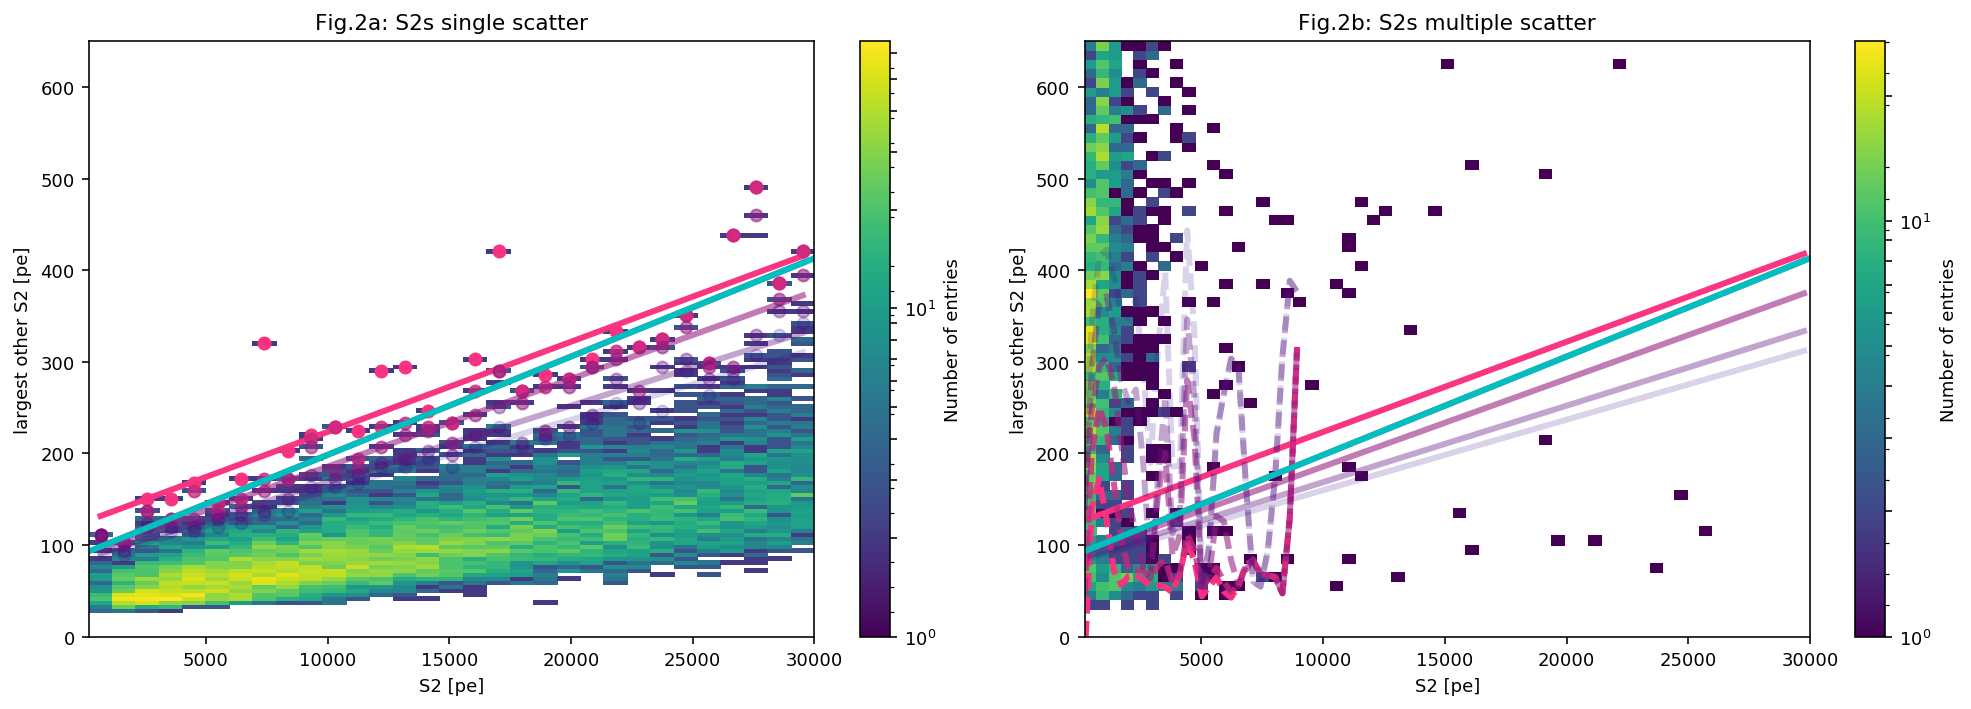

[  1.07450115e-02   9.09815455e+01]


In [64]:
p0 = [1.20e-2,1.04e2]
plt.rcParams['figure.figsize'] = (14, 5)
fig = plt.figure()

s2_0_bounds, s2_1_bounds = [200,3.0e4], [0,650]
########################_s2[1] vs. s2[0] after ionization selections_########################
ax = fig.add_subplot(121)
df_ = sel_rio(df_copy)
mh = Histdd(df_.s2, df_.largest_other_s2,
            bins=(np.linspace(s2_0_bounds[0], s2_0_bounds[1], 32),
                  np.linspace(s2_1_bounds[0], s2_1_bounds[1], 150)))
mh = simplfy_mhs(mh)
mh.plot(log_scale=True,cmap=plt.get_cmap('viridis'))

pcs = [99.8,99.5,99.0,98,97]
plot_sup(smooth = False, fit = True, func = _linears[0])
plt_config(title = 'Fig.2a: S2s single scatter', xbounds = s2_0_bounds, ybounds = s2_1_bounds,
           xlabel = 'S2 [pe]', ylabel = 'largest other S2 [pe]',colorbar = False, sci = False)
x = np.linspace(s2_0_bounds[0], s2_0_bounds[1], 100)
_linears[0].plot(x, options = {'linestyle' : '-', 'linewidth' : 3.0, 'color' : 'c'})
########################_s2[1] vs. s2[0] after multiple scatter selections_########################
ax = fig.add_subplot(122)
df_ = sel_mul(df_copy)
mh = Histdd(df_.s2, df_.largest_other_s2,
            bins=(np.linspace(s2_0_bounds[0], s2_0_bounds[1], 60),
                  np.linspace(s2_1_bounds[0], 5.0e4, 5000)))
mh.plot(log_scale=True,cmap=plt.get_cmap('viridis'))
pcs = [10,20,30,40,50]
plot_sup(smooth = 30, fit = False, func = _linears[0])
plt_config(title = 'Fig.2b: S2s multiple scatter', xbounds = s2_0_bounds, ybounds = s2_1_bounds,
           xlabel = 'S2 [pe]', ylabel = 'largest other S2 [pe]',colorbar = False, sci = False)

x = np.linspace(s2_0_bounds[0], s2_0_bounds[1], 100)
_linears[0].plot(x, options = {'linestyle' : '-', 'linewidth' : 3.0, 'color' : 'c'})

plt.tight_layout()
plt.show()
del df_

_params[2:4] = _linears[0].params
print (_params[2:4])

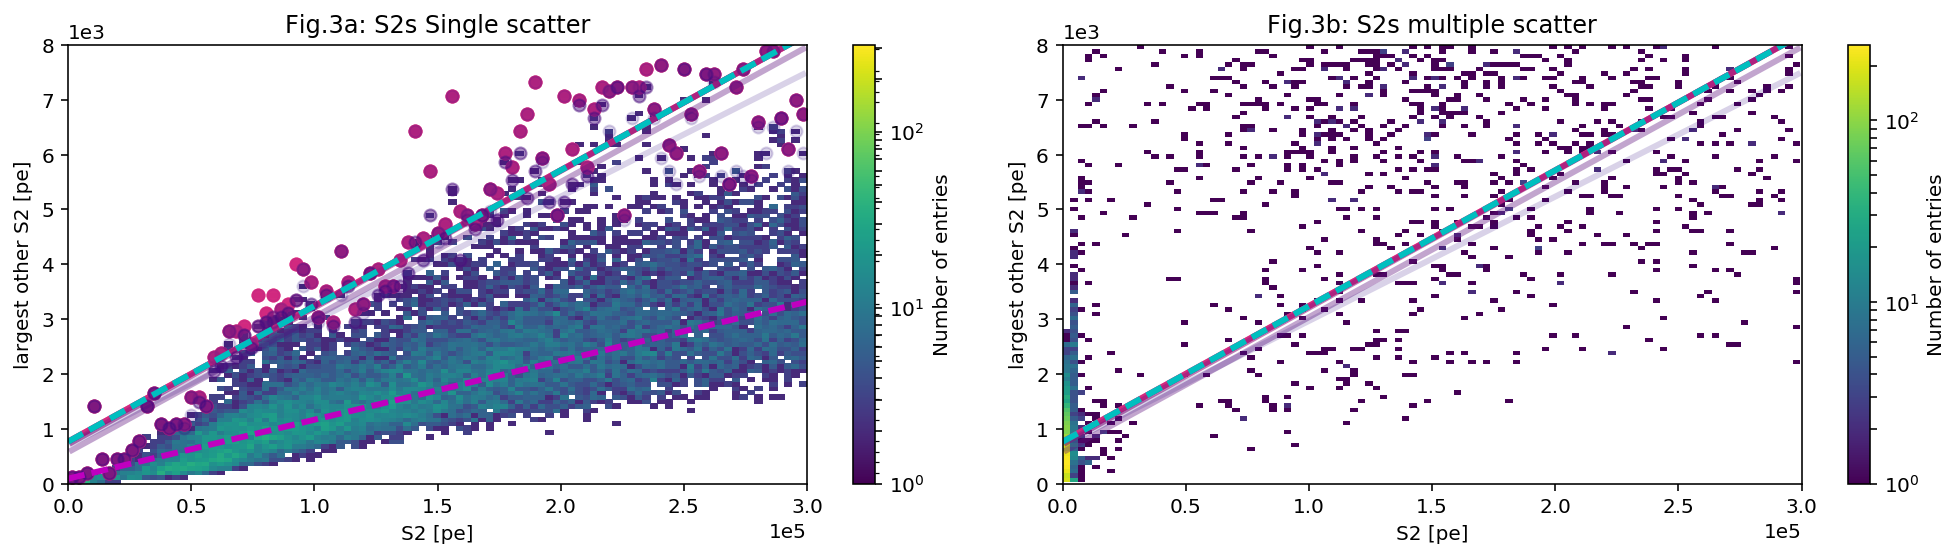

[  2.47307776e-02   7.65877549e+02]


In [84]:
plt.rcParams['figure.figsize'] = (14, 4)
fig = plt.figure()

########################_s2[1] vs. s2[0] after ionization selections_########################
ax = fig.add_subplot(121)
s2_0_bounds, s2_1_bounds = [0,3.0e5], [1,0.8e4]
df_ = sel_ambe(sel_ion(df_copy))
mh = Histdd(df_.s2, df_.largest_other_s2,
            bins=(np.linspace(s2_0_bounds[0], s2_0_bounds[1], 100),
                  np.linspace(s2_1_bounds[0], s2_1_bounds[1], 100)))
mh = simplfy_mhs(mh)
mh.plot(log_scale=True,cmap=plt.get_cmap('viridis'))
plt_config(title = 'Fig.3a: S2s Single scatter', xbounds = s2_0_bounds, ybounds = s2_1_bounds,
           xlabel = 'S2 [pe]', ylabel = 'largest other S2 [pe]',colorbar = False, sci = True)

pcs = [99.9,99.6,99.3,99.,98.7]
plot_sup(fit=True, func = _linears[1])
x = np.linspace(0,s2_0_bounds[1],100)
_linears[0].plot(x, options = {'linestyle' : '--', 'linewidth' : 3.0, 'color' : 'm'})
_linears[1].plot(x, options = {'linestyle' : '--', 'linewidth' : 3.0, 'color' : 'c'})
########################_s2[1] vs. s2[0] after multiple scatter selections_########################
ax = fig.add_subplot(122)
s2_0_bounds = [0,3.0e5]
df_ = sel_ambe(sel_mul(df_copy))
plt.hist2d(df_.s2, df_.largest_other_s2, bins=[100,100], cmin = 1, norm=LogNorm(),cmap=plt.get_cmap('viridis'))
plt_config(title = 'Fig.3b: S2s multiple scatter', xbounds = s2_0_bounds, ybounds = s2_1_bounds,
           xlabel = 'S2 [pe]', ylabel = 'largest other S2 [pe]',colorbar = True, sci = True)

s2_0_bounds, s2_1_bounds = [0.6e5,2.4e5], [1,0.8e5]
df_ = sel_ambe(sel_mul(df_copy))
pcs = [0.1,0.2,0.3,0.4,0.5]
plot_sup(smooth =True, func = _linears[1])
_linears[1].plot(x, options = {'linestyle' : '--', 'linewidth' : 3.0, 'color' : 'c'})


plt.tight_layout()
plt.show()
del df_

_params[4:6] = _linears[1].params
print (_params[4:6])
_params[8] = 1e2

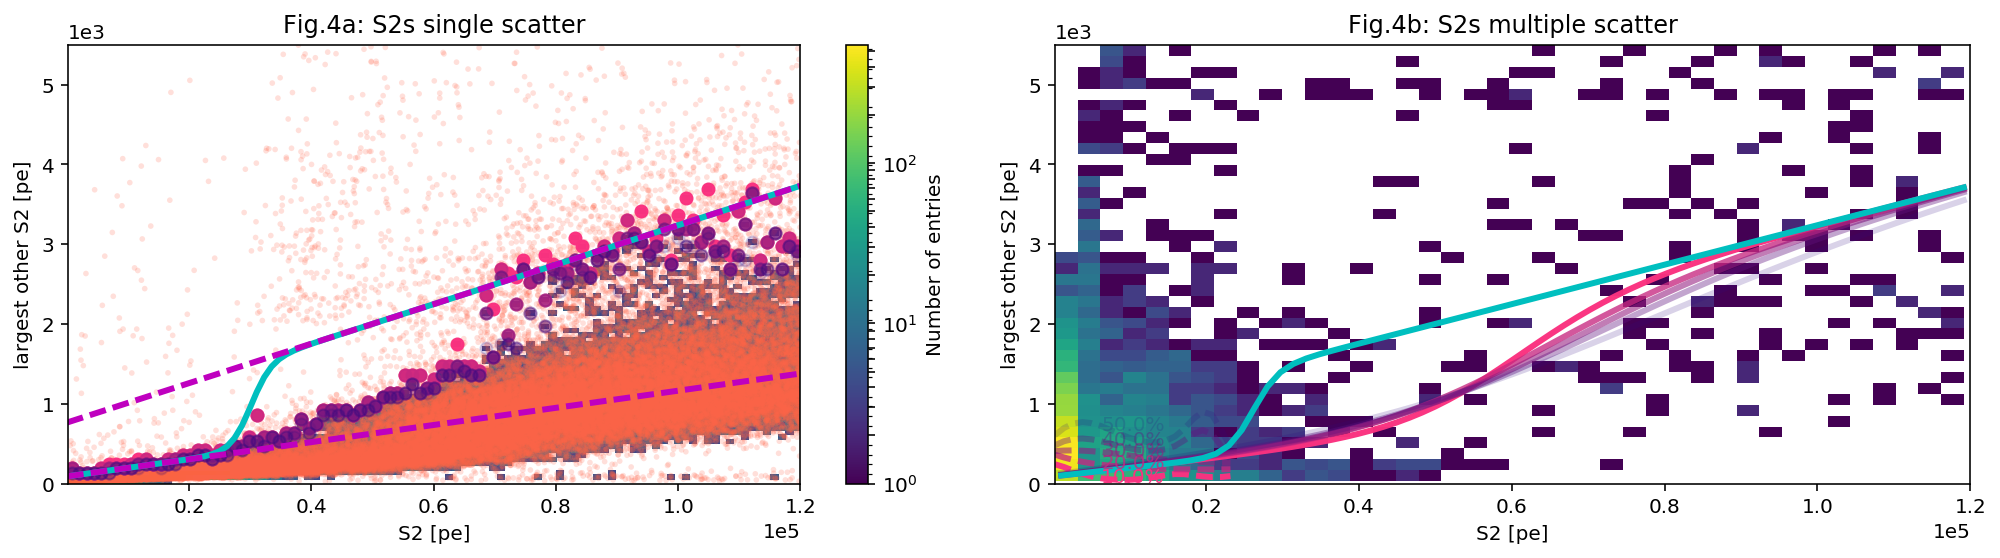

In [36]:
def ses2_size_cut_step2(x,x0,a0):
    k0, b0, k1, b1, k2, b2, c = _params[2:]
    y0, y1 = x*k0+b0, x*k1+b1
    d0, d1 = 1/(np.exp((x-x0)*a0)+1), 1/(np.exp((x0-x)*a0)+1)
    return d1*y1+d0*y0

plt.rcParams['figure.figsize'] = (14, 4)
fig = plt.figure()

nbins = [40,40]
########################_s2[1] vs. s2[0] after ionization selections_########################
ax = fig.add_subplot(121)

s2_0_bounds, s2_1_bounds = [200,1.2e5], [1,5.5e3]
df_ = pd.concat([sel_ion(sel_ambe(df_copy)),sel_rio(df_copy)])
mh = Histdd(df_.s2, df_.largest_other_s2,
            bins=(np.linspace(s2_0_bounds[0], s2_0_bounds[1], 100),
                  np.linspace(s2_1_bounds[0], s2_1_bounds[1], 100)))
mh = simplfy_mhs(mh,level = 3)
mh.plot(log_scale = True, cmap=plt.get_cmap('viridis'))
plt.scatter(df_.s2, df_.largest_other_s2,color='tomato',s=8,edgecolor='none',alpha = 0.2)

pcs = [99.6,99.3,99.0,98.7,98.4]
grey = [0.98,0.78,0.58,0.38,0.18]

p0=[40000,0.01]
result0=[]
x = np.linspace(0,s2_0_bounds[1],100)
for i, pc in enumerate (pcs[:]):
    ph = mh.percentile(pc,1)
    result0.append(curve_fit(ses2_size_cut_step2,ph.bin_centers[:],ph[:],p0))
    plt.plot(ph.bin_centers,ph,'ro',color=[grey[i],grey[i]*0.2,0.5,grey[i]])

plt.plot(ph.bin_centers,ses2_size_cut_step2(ph.bin_centers,*[3.0e4,6.0e-4]),'c-',linewidth = 3.)
plt_config(title = 'Fig.4a: S2s single scatter', xbounds = s2_0_bounds, ybounds = s2_1_bounds,
           xlabel = 'S2 [pe]', ylabel = 'largest other S2 [pe]',colorbar = False)

x = np.linspace(0,s2_0_bounds[1],100)
_linears[0].plot(x, options = {'linestyle' : '--', 'linewidth' : 3.0, 'color' : 'm'})
_linears[1].plot(x, options = {'linestyle' : '--', 'linewidth' : 3.0, 'color' : 'm'})
########################_s2[1] vs. s2[0] after multiple scatter selections_########################
ax = fig.add_subplot(122)
df_ = sel_ambe(sel_mul(df_copy))

mh = Histdd(df_.s2, df_.largest_other_s2,
bins=(np.linspace(s2_0_bounds[0], 1.2e5, 72),
      np.linspace(s2_1_bounds[0], 1.2e5, 1000)))
grey = [0.98,0.78,0.58,0.38,0.18]
pcs = [10,20,30,40,50]
for i, d in enumerate(pcs):
    ph = mh.percentile(d,1)
    sx = np.linspace(s2_0_bounds[0],s2_0_bounds[1],100)
    s = UnivariateSpline(ph.bin_centers,np.log10(ph),s=2.0)
    sy = 10**s(sx)
    plt.text(sx[5],sy[5]-0.05e3,'%.1f%%' %d,color=[grey[i],grey[i]*0.2,0.5,grey[i]])
    plt.plot(sx[:20],sy[:20],'--',color=[grey[i],grey[i]*0.2,0.5,grey[i]],linewidth=3.0)
for i in range(5):
    plt.plot(ph.bin_centers,ses2_size_cut_step2(ph.bin_centers,*(result0[i][0])),'r-',linewidth = 3.,color=[grey[i],grey[i]*0.2,0.5,grey[i]])

plt.plot(ph.bin_centers,ses2_size_cut_step2(ph.bin_centers,*[2.6e4,6.0e-4]),'r-',linewidth = 3.,color = 'c')

plt.hist2d(df_.s2, df_.largest_other_s2, bins=nbins, cmin = 0.0, norm=LogNorm(),cmap=plt.get_cmap('viridis'))
#plt.scatter(df_.s2, df_.largest_other_s2,color='tomato',s=8,edgecolor='none',alpha = 0.4)

plt_config(title = 'Fig.4b: S2s multiple scatter', xbounds = s2_0_bounds, ybounds = s2_1_bounds,
           xlabel = 'S2 [pe]', ylabel = 'largest other S2 [pe]',colorbar = False)

plt.tight_layout()
plt.show()
del df_
_params[:2] = [2.6e4,6.0e-4]

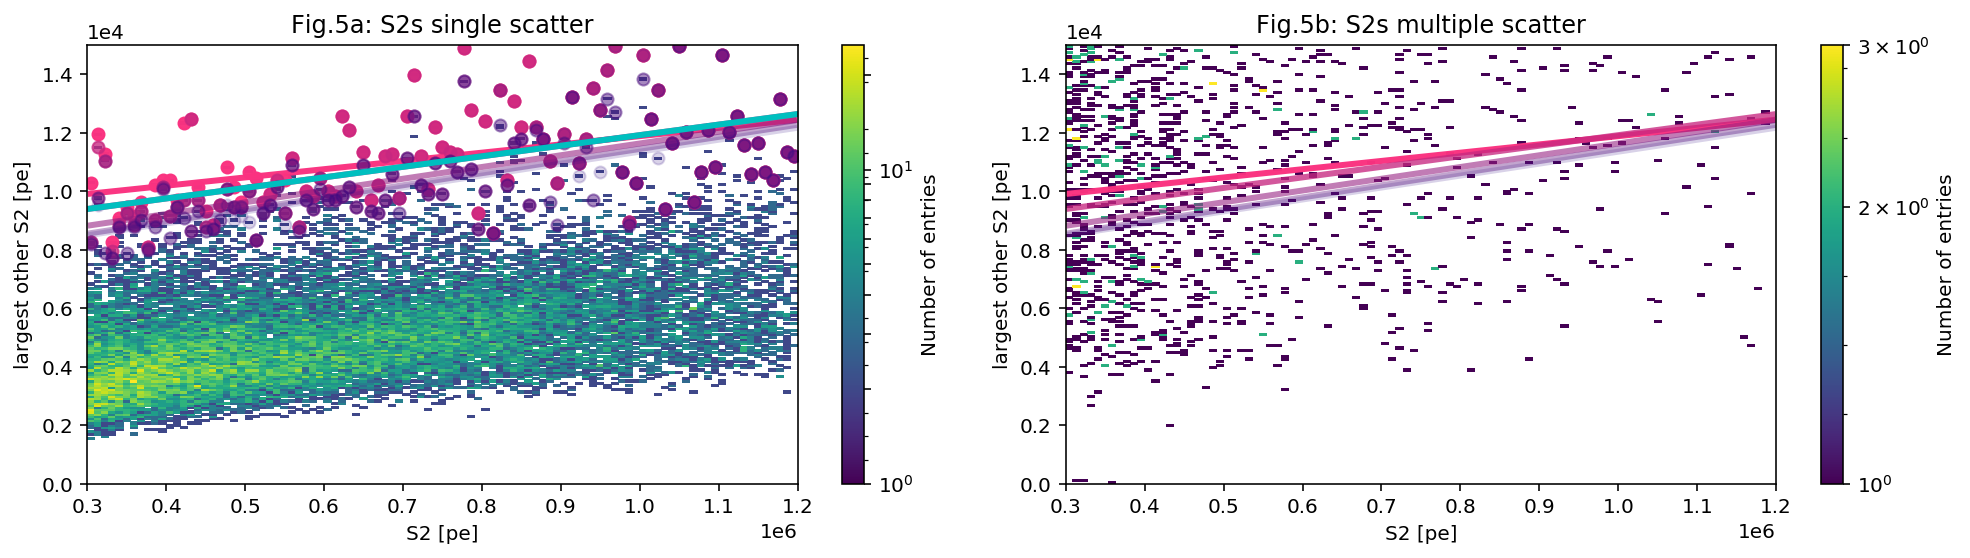

[  3.60708186e-03   8.30416738e+03]


In [35]:
plt.rcParams['figure.figsize'] = (14, 4)
fig = plt.figure()

nbins = 100
########################_s2[1] vs. s2[0] after ionization selections_########################
ax = fig.add_subplot(121)
s2_0_bounds, s2_1_bounds = [3e5,12e5], [1,1.5e4]
df_ = sel_ion(df_copy)
mh = Histdd(df_.s2, df_.largest_other_s2,
            bins=(np.linspace(s2_0_bounds[0], s2_0_bounds[1], 100),
                  np.linspace(s2_1_bounds[0], s2_1_bounds[1], 200)))
mh = simplfy_mhs(mh,level = 1)
mh.plot(log_scale=True,cmap=plt.get_cmap('viridis'))
plt_config(title = 'Fig.5a: S2s single scatter', xbounds = s2_0_bounds, ybounds = s2_1_bounds,
           xlabel = 'S2 [pe]', ylabel = 'largest other S2 [pe]',colorbar = False)

nbins = [60,100]
pcs = [99.7,99.5,99.3,99.1,99.0]
plot_sup(smooth = False, fit = True, func = _linears[2])
x = np.linspace(s2_0_bounds[0], s2_0_bounds[1], 100)
_linears[2].plot(x, options = {'linestyle' : '-', 'linewidth' : 3.0, 'color' : 'c'})

ax = fig.add_subplot(122)
s2_0_bounds, s2_1_bounds = [3e5,12e5], [1,1.5e4]
df_ = sel_mul(df_copy)
mh = Histdd(df_.s2, df_.largest_other_s2,
            bins=(np.linspace(s2_0_bounds[0], s2_0_bounds[1], 100),
                  np.linspace(s2_1_bounds[0], s2_1_bounds[1], 200)))
mh.plot(log_scale=True,cmap=plt.get_cmap('viridis'))
plt_config(title = 'Fig.5b: S2s multiple scatter', xbounds = s2_0_bounds, ybounds = s2_1_bounds,
           xlabel = 'S2 [pe]', ylabel = 'largest other S2 [pe]',colorbar = False)
pcs = [0.2,0.4,0.6,0.8,1.0]
plot_sup(smooth = True, fit = False, func = _linears[2])

plt.tight_layout()
plt.show()

del df_
_params[6:8] = _linears[2].params
print (_params[6:8])

In [5]:
# define ses2_size_cut
def ses2_size_cut(s2_area):
    linear_0 = s2_area * 0.01 + 90
    linear_1 = s2_area * 0.025 + 766
    fermi_dirac_coef_0 = 1 / (np.exp((s2_area - 26000) * 6e-4) + 1) 
    fermi_dirac_coef_1 = 1 / (np.exp((26000 - s2_area) * 6e-4) + 1)
    return linear_0*fermi_dirac_coef_0+linear_1*fermi_dirac_coef_1

def ses2_size_cut_ori(s2_area):
    linear_0 = s2_area * 0.00832 + 72.3
    linear_1 = s2_area * 0.03 - 109
    fermi_dirac_coef_0 = 1 / (np.exp((s2_area - 23300) * 5.91e-4) + 1)
    fermi_dirac_coef_1 = 1 / (np.exp((23300 - s2_area) * 5.91e-4) + 1)
    return linear_0*fermi_dirac_coef_0+linear_1*fermi_dirac_coef_1

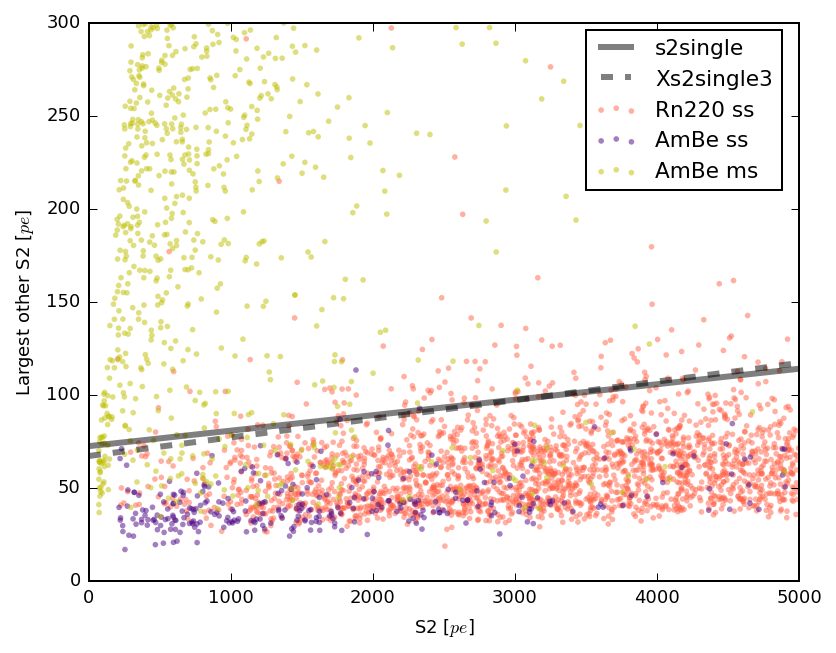

In [12]:
matplotlib.rc('font', size = 9)
plt.rcParams['figure.figsize'] = (14, 5)
fig = plt.figure()

s2_0_bounds, s2_1_bounds = [200,5000], [0,300]
ax = fig.add_subplot(121)

sel_box = lambda df: df[(df.largest_other_s2<s2_1_bounds[1]) &
                        (df.s2<s2_0_bounds[1])]

df_ = sel_rio((df_copy))
plt.scatter(df_.s2, df_.largest_other_s2,color='tomato',s=8,edgecolor='none',alpha = 0.5)

df_ = sel_ambe(sel_ion(df_copy))
plt.scatter(df_.s2, df_.largest_other_s2,color='indigo',s=8,edgecolor='none', alpha = 0.5)

s2_0_bounds,s2_1_bounds = [0,5000],[0,300]
df_ = sel_ambe(sel_mul(df_copy))
plt.scatter(df_.s2, df_.largest_other_s2,color='y',s=8,edgecolor='none', alpha = 0.5)
    
plt_config(title = '', xbounds = [0,5000], ybounds = s2_1_bounds,
           xlabel = 'S2 [$pe$]', ylabel = 'Largest other S2 [$pe$]',colorbar = False, sci = False)

x = np.linspace(s2_0_bounds[0],s2_0_bounds[1],100)
#plt.plot(x,ses2_size_cut(x),'r--',lw=3)
plt.plot(x,ses2_size_cut_ori(x),'k-',lw=3, alpha = 0.5)
plt.plot(x,67+x/100.,'k--',lw=3,alpha = 0.5)
#plt.legend(['New','Old','Rn220','AmBe ss','AmBe ms'],loc=[0.7,0.7])
plt.legend(['s2single','Xs2single3','Rn220 ss','AmBe ss','AmBe ms'],loc=[0.7,0.7])

s2_0_bounds, s2_1_bounds = [200,5000], [0,300]
df_ = sel_rio((df_copy))
sel_emg = lambda df:df[(df_.largest_other_s2>ses2_size_cut_ori(df_.s2)) &
                       (df_.s2<1000)
                      ]
df_ = sel_emg(df_)
#plt.scatter(df_.s2, df_.largest_other_s2,color='k',s=46,edgecolor='none',marker = '+')

plt.show()

In [51]:
s2_0_bounds, s2_1_bounds = [200,5000], [0,300]
df_ = sel_rio((df_copy))
sel_emg = lambda df:df[(df_.largest_other_s2>ses2_size_cut_ori(df_.s2)) &
                       (df_.s2<1000)
                      ]
df_ = sel_emg(df_)
#print (len(df_))

for i, run in enumerate(df_.run_number.unique()):
    sett = setname[setname.number==run]
    print (sett.number.values)
    print (sett.raw_data_used_local_path.values[0]+'/'+sett.name.values[0])
    for evt in df_[df_.run_number==run].event_number.values[:25]:
        print (evt, end = '\n')
    if i>0:
        #print ('\n', end = '')
        continue
    
del df_

[5674]
/project2/lgrandi/xenon1t/raw/161224_1511
268503
[5687]
/project2/lgrandi/xenon1t/raw/161225_0415
233901
[5659]
/project2/lgrandi/xenon1t/raw/161223_2153
179834
[5656]
/project2/lgrandi/xenon1t/raw/161223_1852
202053
[5629]
/project2/lgrandi/xenon1t/raw/161223_0447
112785
[5678]
/project2/lgrandi/xenon1t/raw/161224_1912
289260
[5702]
/project2/lgrandi/xenon1t/raw/161225_1920
87404


In [23]:
dic = {'x' : 1}


 ^s2    |  350|  650|  950| 1250| 1550| 1850| 2150| 2450| 2750| 3050| 3350| 3650| 3950| 4250| 4550| 4850| 
 ^values| 0.8421| 0.8696| 0.9184| 0.9457| 0.9407| 0.9366| 0.9497| 0.9146| 0.9337| 0.9223| 0.9581| 0.9591| 0.9302| 0.9521| 0.9521| 0.9693| 
 ^up err| 0.0696| 0.0584| 0.0333| 0.0205| 0.0193| 0.0184| 0.0155| 0.0200| 0.0168| 0.0177| 0.0129| 0.0134| 0.0177| 0.0140| 0.0147| 0.0117| 
 ^low err|0.0919| 0.0787| 0.0445| 0.0269| 0.0242| 0.0224| 0.0192| 0.0234| 0.0200| 0.0206| 0.0161| 0.0170| 0.0210| 0.0172| 0.0183| 0.0156| 

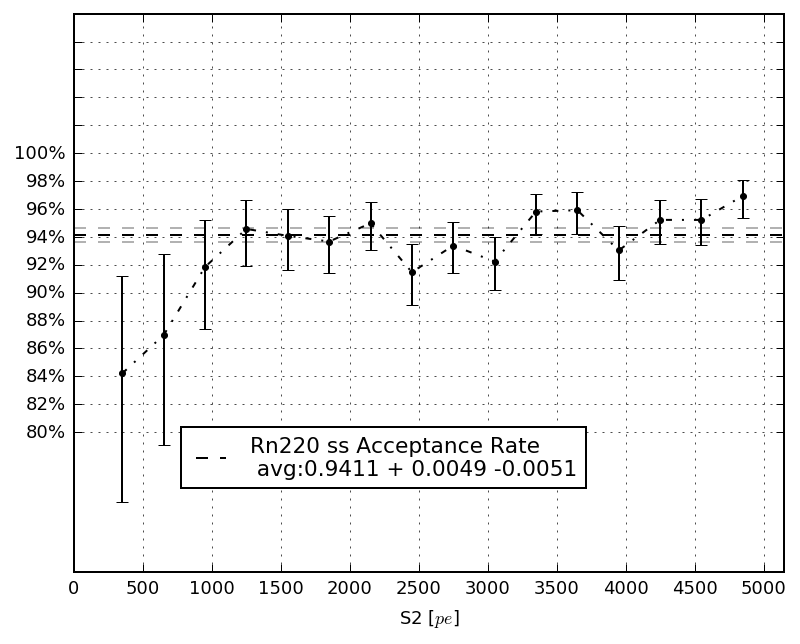


 ^s2    |  350|  650|  950| 1250| 1550| 1850| 2150| 2450| 2750| 3050| 3350| 3650| 3950| 4250| 4550| 4850| 
 ^values| 0.9694| 0.9700| 0.9744| 0.9711| 0.9626| 0.9594| 0.9887| 0.9680| 0.9714| 0.9000| 0.9286| 0.9070| 0.9024| 1.0000| 0.9655| 0.9333| 
 ^up err| 0.0090| 0.0068| 0.0064| 0.0075| 0.0096| 0.0109| 0.0063| 0.0134| 0.0135| 0.0285| 0.0267| 0.0378| 0.0395| -0.0000| 0.0246| 0.0464| 
 ^low err|0.0111| 0.0080| 0.0076| 0.0090| 0.0115| 0.0131| 0.0102| 0.0184| 0.0196| 0.0343| 0.0347| 0.0501| 0.0523| 0.0400| 0.0472| 0.0846| 

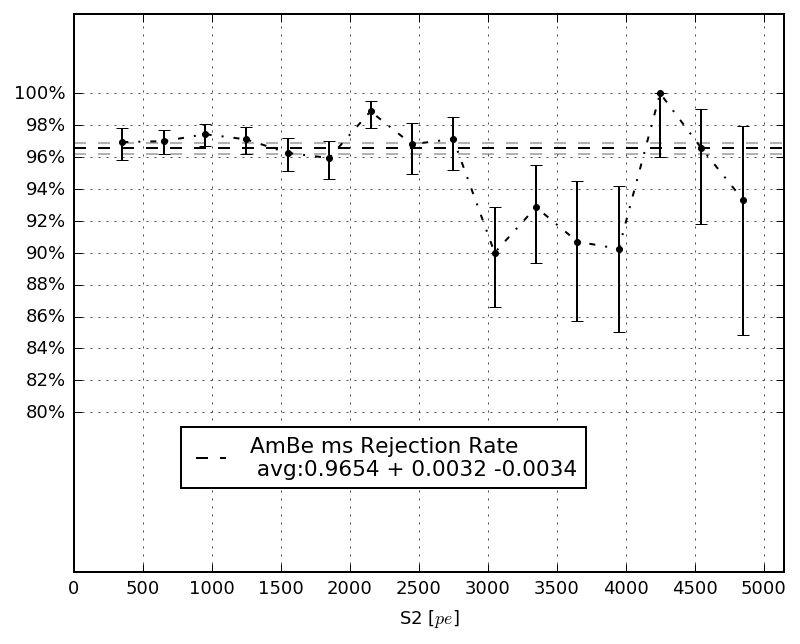

In [7]:
matplotlib.rc('font', size = 9)
plt.rcParams['figure.figsize'] = (14, 5)
fig = plt.figure()
from scipy.stats import beta

def f(x,rv):
    return rv.ppf(rv.cdf(x)+0.68)-x

def error_eff(pha,pht):
    rv = [beta(pha[i]+1,pht[i]-pha[i]+1) for i in range(len(pha[:]))]
    bounds = [(rv[i].ppf(0),rv[i].ppf(0.319)) for i in range(len(pha[:]))]
    low = [pha[i]/pht[i]-minimize(f,0.1,rv[i],bounds=(bounds[i],)).x[0] for i in range(len(pha[:]))]
    high = [f(pha[i]/pht[i]-low[i],rv[i])-low[i] for i in range(len(pha[:]))]
    return low,high

def plot_eff(c,eff_type = 'acc',bias = 0.7,cut = None):
    global s2_0_bounds, s2_1_bounds, dt_bounds, width_bounds
    s2_0_bounds, s2_1_bounds = [200,5000], [0,300]
    if eff_type == 'acc':
        df_['acc'] = 0.5+0.5*(cut(df_.s2)-df_.largest_other_s2)/abs(df_.largest_other_s2-cut(df_.s2))
    elif eff_type == 'rej':
        df_['acc'] = 0.5+0.5*(df_.largest_other_s2-cut(df_.s2))/abs(df_.largest_other_s2-cut(df_.s2))
    
    mh = Histdd(df_.s2, df_.acc,
                axis_names=('S2', 'acc'),
                bins=(np.linspace(s2_0_bounds[0], s2_0_bounds[1], 17),
                      np.linspace(-0.5, 1.5, 3)))
    pht= mh.projection(axis=0)
    pha = mh.average(axis=1)
    print('\n ^s2', end = '    | ')
    [ print('%4d' %va,end = '| ') for va in pha.bin_centers[:]]
    print('\n ^values', end = '| ')
    [ print('%.4f' %va,end = '| ') for va in pha[:]]
    
    
    pha[:] *= pht[:]
    
    low,high = error_eff(pha,pht)
    print('\n ^up err', end = '| ')
    [ print('%.4f' %va,end = '| ') for va in high[:]]
    print('\n ^low err', end = '|')
    [ print('%.4f' %va,end = '| ') for va in low[:]]
    plt.errorbar(pht.bin_centers,pha[:]/pht[:]-bias,yerr=[low,high],fmt='.',color=c,ls='-.',capsize=3.)
    plot_options = {'xmin':0,'xmax':1,'color':c, 'ls':'--', 'lw':1.}
    plt.axhline(y=np.average(df_.acc)-bias, **plot_options)
    low,high = error_eff([sum(pha[:])],[sum(pht[:])])
    plt.axhline(y=np.average(df_.acc)-bias-low, alpha =0.3,**plot_options)
    plt.axhline(y=np.average(df_.acc)-bias+high, alpha =0.3,**plot_options)
    
    #print ('%d,%d,%d' %(np.average(df_.acc),low,high))
    return np.average(df_.acc), low, high

labels = ['%d%%'%(i*2+80) for i in range(11)]
if False:"""
########################_efficiency plots_########################
ax = fig.add_subplot(121)
df_ = sel_ambe(sel_ion(df_copy))
#acc_new = plot_eff('r',eff_type ='acc',bias = 0.7,cut = ses2_size_cut)
acc_old = plot_eff('k',eff_type ='acc',bias = 0.7,cut = ses2_size_cut_ori)

#plt.legend(['AmBe ss Acceptance Rate (%.4f) new'%acc_new,
            #'AmBe ss Acceptance Rate (%.4f) old'%acc_old],loc=[0.15,0.25])
plt.legend(['AmBe ss Acceptance Rate (%.4f)'%acc_old],loc=[0.15,0.15])

plt_config(title = '', xbounds = [0,5150], ybounds = [0,0.35],
           xlabel = 'S2 [$pe$]', ylabel = '',colorbar = False, sci = False)
plt.xticks(np.asarray([i*500 for i in range(11)]),color='k')
plt.yticks(np.asarray([i*0.02+0.1 for i in range(16)]),labels,color='k')
ax.grid(which = 'minor', alpha = 0.3)
ax.grid(which = 'major', alpha = 0.7)
plt.show()"""
########################_efficiency plots_########################
fig = plt.figure()
ax = fig.add_subplot(121)

df_ = sel_rio(df_copy)
#acc_new = plot_eff('r',eff_type ='acc',bias = 0.7,cut = ses2_size_cut)
acc_old, low, high = plot_eff('k',eff_type ='acc',bias = 0.7,cut = ses2_size_cut_ori)
low, high = low[0], high[0]
#plt.legend(['Rn220 ss Acceptance Rate (%.4f) new'%acc_new,
            #'Rn220 ss Acceptance Rate (%.4f) old'%acc_old],loc=[0.15,0.25])
plt.legend(['Rn220 ss Acceptance Rate \n avg:%.4f + %.4f -%.4f'%(acc_old,high,low)],loc=[0.15,0.15])

plt_config(title = '', xbounds = [0,5150], ybounds = [0,0.35],
           xlabel = 'S2 [$pe$]', ylabel = '',colorbar = False, sci = False)

plt.xticks(np.asarray([i*500 for i in range(11)]),color='k')
plt.yticks(np.asarray([i*0.02+0.1 for i in range(16)]),labels,color='k')
ax.grid(which = 'minor', alpha = 0.3)
ax.grid(which = 'major', alpha = 0.7)
plt.show()
#####################################################################
fig = plt.figure()
ax = fig.add_subplot(121)
s2_0_bounds, s2_1_bounds = [200,5000], [0,5.0e3]
df_ = sel_ambe(sel_mul(df_copy))
#rej_new = plot_eff('r',eff_type ='rej',bias = 0.7,cut = ses2_size_cut)
rej_old, low, high = plot_eff('k',eff_type ='rej',bias = 0.7,cut = ses2_size_cut_ori)
low, high = low[0], high[0]
#plt.legend(['AmBe ms Rejection Rate (%.4f) new'%rej_new,
            #'AmBe ms Rejection Rate (%.4f) old'%rej_old],loc=[0.15,0.25])
plt.legend(['AmBe ms Rejection Rate \n avg:%.4f + %.4f -%.4f'%(rej_old,high,low)],loc=[0.15,0.15])

plt_config(title = '', xbounds = [0,5150], ybounds = [0,0.35],
           xlabel = 'S2 [$pe$]', ylabel = '',colorbar = False, sci = False)
plt.xticks(np.asarray([i*500 for i in range(11)]),color='k')
plt.yticks(np.asarray([i*0.02+0.1 for i in range(11)]),labels,color='k')
ax.grid(which = 'minor', alpha = 0.3)
ax.grid(which = 'major', alpha = 0.7)
plt.show()
########### End ################
del df_